# Welcome to the British Airway Job simulation Project

# Business Statement
## Objective:
#### To support British Airways in improving customer satisfaction and booking rates by leveraging insights from customer reviews and flight booking data.

## Approach:

### Task 1: 
  ##### Performed web scraping on verified customer reviews from AirlineQuality.com using BeautifulSoup. Cleaned and analyzed the data to uncover key themes and sentiments using techniques like topic modeling and RAG-based systems for deeper analysis.

### Task 2:
  ##### Prepared a machine learning model to predict booking decisions. Applied feature engineering and evaluated multiple classification models, identifying Random Forest as the top-performing model with 88% cross-validation accuracy. Also visualized key features influencing booking behavior.

## Impact:
### hese insights empower British Airways to identify what drives customer satisfaction and bookings, enabling targeted improvements to services and better allocation of marketing efforts.



In [463]:
# import all the necessary libraries 

import pandas as pd
from bs4 import BeautifulSoup
import  requests
import time
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from langchain_google_genai import  ChatGoogleGenerativeAI
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts  import PromptTemplate
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter
from IPython.display import Markdown
from transformers import pipeline
from gensim import corpora
from langchain.document_loaders import TextLoader
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain.vectorstores import Chroma
import google.generativeai as genai
import transformers
from gensim.models import LdaModel
from wordcloud import WordCloud
import numpy as np
import warnings
warnings.simplefilter(action= 'ignore')

###   Web scraping reviews from below website (url)

In [102]:
url = f"https://www.airlinequality.com/airline-reviews/british-airways"

In [96]:
response = requests.get(url)

In [97]:
response.status_code

200

In [98]:
soup = BeautifulSoup(response.content, 'html.parser')

In [99]:
list_reviews = soup.find_all('article',{'itemprop':'review' })

In [100]:
len(list_reviews)

10

In [101]:
list_reviews[0]

<article class="comp comp_media-review-rated list-item media position-content review-922520" itemprop="review" itemscope="" itemtype="http://schema.org/Review">
<meta content="2025-04-15" itemprop="datePublished"/>
<div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
<span itemprop="ratingValue">9</span>/<span itemprop="bestRating">10</span>
</div>
<div class="body" id="anchor922520">
<h2 class="text_header">"exceeded my expectations"</h2>
<h3 class="text_sub_header userStatusWrapper">
<span itemprop="author" itemscope="" itemtype="http://schema.org/Person">
<span itemprop="name">J Peale</span></span> (United Kingdom) <time datetime="2025-04-15" itemprop="datePublished">15th April 2025</time></h3>
<div class="tc_mobile">
<div class="text_content" itemprop="reviewBody">✅ <strong><a href="https://www.airlinequality.com/verified-reviews/"><em>Trip Verified</em></a></strong> |   Punta Cana Terminal B check in was straightforward with separate Clu

## Data i want to extract and analysis

1- reviews

2- Seat type

In [75]:
# Review

review  = list_reviews[0].find('div',{'itemprop':'reviewBody'}).get_text()

In [76]:
review 

"Not Verified |  Check in was smooth enough. Boarding was chaotic. We were herded through the gate only to be held for a seemingly never ending period of time outside next to the apron. We are BA silver members and noticed that despite business class being nearly empty we were not offered the chance to move up a class. The seat pocket in front of me full of the previous passenger's rubbish.  On arrival at Heathrow, our bags took a long time to reach the belt and plenty arrived before ours even though ours were supposed to be priority."

In [77]:
# Seat Type

seat_type  = list_reviews[4].find('td',{'class':'review-rating-header cabin_flown'}).find_next_sibling('td').get_text()

In [78]:
seat_type.strip()

'Business Class'

In [79]:
# using "for loop" to extract data from the first page of the url

reviews = []
seat_types = []

for result in list_reviews: 
    review = result.find('div', {'itemprop': 'reviewBody'}).get_text().strip()
    seat_type = result.find('td', {'class': 'review-rating-header cabin_flown'}).find_next_sibling('td').get_text().strip()

    reviews.append(review)
    seat_types.append(seat_type)

data = {
    'reviews': reviews,
    'seat_types': seat_types
}

In [80]:
df = pd.DataFrame(data)

In [81]:
df

,reviews,seat_types
0,Not Verified | Check in was smooth enough. Bo...,Economy Class
1,✅ Trip Verified | Although transferring to thi...,Economy Class
2,✅ Trip Verified | We are extremely grateful ...,Economy Class
3,✅ Trip Verified | I had an appalling experie...,Economy Class
4,"Not Verified | Good points, the cabin crew, t...",Business Class
5,"Not Verified | It was a decent flight, reason...",Economy Class
6,✅ Trip Verified | I really like flying Briti...,Business Class
7,✅ Trip Verified | Could not book online the ...,Economy Class
8,✅ Trip Verified | Having had some rough experi...,Economy Class
9,✅ Trip Verified | This comfortable flight wa...,First Class


In [113]:
## Now iterating through to 199 pages 

reviews = []
seat_types = []

for page in range(1, 200):  
    url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    list_reviews = soup.find_all('article', {'itemprop': 'review'})

    for result in list_reviews:
        try:
            review = result.find('div', {'itemprop': 'reviewBody'}).get_text().strip()
            seat_type = result.find('td', {'class': 'review-rating-header cabin_flown'}).find_next_sibling('td').get_text().strip()
            
            reviews.append(review)
            seat_types.append(seat_type)
            
        except AttributeError:
            continue 

data = {
    'reviews': reviews,
    'seat_types': seat_types
}


In [114]:
df = pd.DataFrame(data)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviews     1990 non-null   object
 1   seat_types  1990 non-null   object
dtypes: object(2)
memory usage: 31.2+ KB


In [117]:
(df).head()

1990

In [129]:
## scraped data saved 

df.to_csv('/Users/sot/Desktop/RESUME/British_Airways/BA_review_data.csv',index= False)

In [131]:
## loading the scraped date

data = pd.read_csv(r'/Users/sot/Desktop/RESUME/British_Airways/BA_review_data.csv')
data

,reviews,seat_types
0,Not Verified | Check in was smooth enough. Bo...,Economy Class
1,✅ Trip Verified | Although transferring to thi...,Economy Class
2,✅ Trip Verified | We are extremely grateful ...,Economy Class
3,✅ Trip Verified | I had an appalling experie...,Economy Class
4,"Not Verified | Good points, the cabin crew, t...",Business Class
...,...,...
1985,✅ Verified Review | British Airways has got it...,Economy Class
1986,✅ Verified Review | London to New York. It has...,Economy Class
1987,✅ Verified Review | Flight from Gatwick to Gr...,Business Class
1988,✅ Verified Review | Flew from Lisbon to Londo...,Economy Class


In [135]:
data['reviews'][1].split('|', 1)[-1].strip()

"Although transferring to this flight through Heathrow from Budapest took almost an hour, the flight crew was welcoming and friendly as we boarded at the last minute. I had tried to reserve a vegetarian meal online the day before the flight but couldn't, and asked Sarah, the head flight attendant, if they might be able to provide one. She not only found a delicious meal from Premium, Economy, but was especially caring and helpful throughout the flight. The flight attendants also offered water and juice several times during the flight. I was also impressed with the wide range of entertainment offerings, which included some first-rate films."

In [136]:
## cleaning the review column

data['reviews'] = [review.split('|', 1)[-1].strip() for review in data['reviews']]


In [137]:
data

,reviews,seat_types
0,Check in was smooth enough. Boarding was chaot...,Economy Class
1,Although transferring to this flight through H...,Economy Class
2,We are extremely grateful to the crew of fligh...,Economy Class
3,I had an appalling experience with British Air...,Economy Class
4,"Good points, the cabin crew, they were helpful...",Business Class
...,...,...
1985,British Airways has got it wrong on short Euro...,Economy Class
1986,London to New York. It has been a long time si...,Economy Class
1987,Flight from Gatwick to Grenada return with Bri...,Business Class
1988,Flew from Lisbon to London and return. British...,Economy Class


In [140]:
data['seat_types'].value_counts()

seat_types
Economy Class      1101
Business Class      642
Premium Economy     174
First Class          73
Name: count, dtype: int64

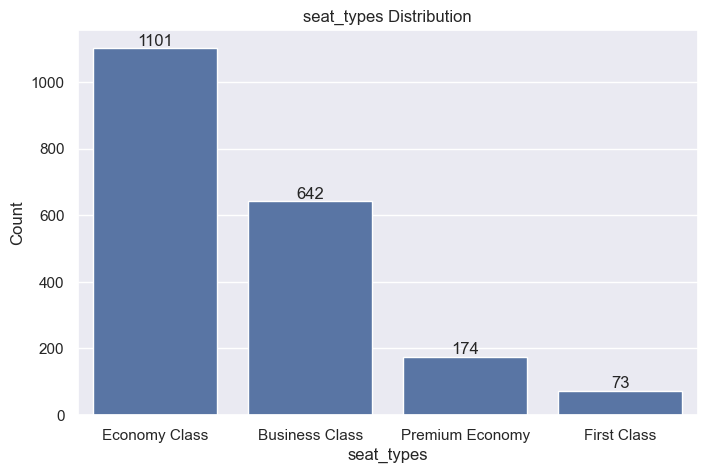

In [142]:
seatTypes_counts = data['seat_types'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
seatTypes = sns.countplot(data=data, x='seat_types', order=seatTypes_counts.index)

for p in seatTypes.patches:
    seatTypes.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("seat_types Distribution")
plt.xlabel("seat_types")
plt.ylabel("Count")
plt.show()

In [144]:
nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/sot/nltk_data...


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data]   Unzipping corpora/stopwords.zip.


In [145]:
##  Creating the preprocessing function

class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=False, stem=False):
        self.lower = lower
        self.stem = stem

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def text_processing(text):
            if not isinstance(text, str):
                text = ""

            processed_text = re.sub('[^a-zA-Z]', ' ', text)
            if self.lower:
                processed_text = processed_text.lower()
            processed_text = processed_text.split()
            if self.stem:
                ps = PorterStemmer()
                stop_words = set(stopwords.words('english'))
                processed_text = [ps.stem(word) for word in processed_text if word not in stop_words]
            return ' '.join(processed_text)

        return [text_processing(text) for text in X]


In [146]:
text_processor = TextProcessor(lower=True, stem=True)

In [147]:
data['reviews']  = data['reviews'] .astype(str) 
data['processed_reviews'] = text_processor.fit_transform(data['reviews'])

In [148]:
data

,reviews,seat_types,processed_reviews
0,Check in was smooth enough. Boarding was chaot...,Economy Class,check smooth enough board chaotic herd gate he...
1,Although transferring to this flight through H...,Economy Class,although transfer flight heathrow budapest too...
2,We are extremely grateful to the crew of fligh...,Economy Class,extrem grate crew flight ba cape town heathrow...
3,I had an appalling experience with British Air...,Economy Class,appal experi british airway start tri check on...
4,"Good points, the cabin crew, they were helpful...",Business Class,good point cabin crew help profession matur qu...
...,...,...,...
1985,British Airways has got it wrong on short Euro...,Economy Class,british airway got wrong short european haul m...
1986,London to New York. It has been a long time si...,Economy Class,london new york long time sinc british airway ...
1987,Flight from Gatwick to Grenada return with Bri...,Business Class,flight gatwick grenada return british airway l...
1988,Flew from Lisbon to London and return. British...,Economy Class,flew lisbon london return british airway never...


In [154]:
## loading the sentiment analysis model  from hugging face

classifier = pipeline("text-classification", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0


In [159]:
#  A simple function to return the analysis

def score(review):
    result = classifier(review, truncation=True)
    return result[0]['label']


In [160]:
#Applying the function to my data and creating a new column

data['sentiment_analysis'] = data['processed_reviews'].apply(score)

In [161]:
data

,reviews,seat_types,processed_reviews,sentiment_analysis
0,Check in was smooth enough. Boarding was chaot...,Economy Class,check smooth enough board chaotic herd gate he...,NEGATIVE
1,Although transferring to this flight through H...,Economy Class,although transfer flight heathrow budapest too...,POSITIVE
2,We are extremely grateful to the crew of fligh...,Economy Class,extrem grate crew flight ba cape town heathrow...,POSITIVE
3,I had an appalling experience with British Air...,Economy Class,appal experi british airway start tri check on...,NEGATIVE
4,"Good points, the cabin crew, they were helpful...",Business Class,good point cabin crew help profession matur qu...,NEGATIVE
...,...,...,...,...
1985,British Airways has got it wrong on short Euro...,Economy Class,british airway got wrong short european haul m...,NEGATIVE
1986,London to New York. It has been a long time si...,Economy Class,london new york long time sinc british airway ...,NEGATIVE
1987,Flight from Gatwick to Grenada return with Bri...,Business Class,flight gatwick grenada return british airway l...,NEGATIVE
1988,Flew from Lisbon to London and return. British...,Economy Class,flew lisbon london return british airway never...,NEGATIVE


In [162]:
data['sentiment_analysis'].value_counts()

sentiment_analysis
NEGATIVE    1796
POSITIVE     194
Name: count, dtype: int64

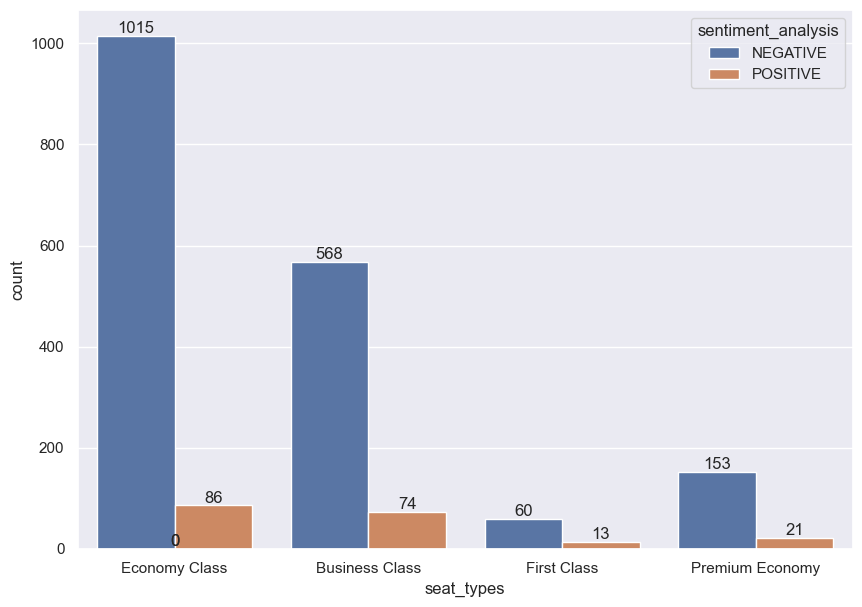

In [170]:
plt.figure(figsize = (10,7))
seat_types = sns.countplot(data = data,x = 'seat_types',hue = 'sentiment_analysis')

for p in seat_types.patches:
   seat_types.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

# Topic Modeling Visualization

In [173]:

cleaned_reviews = text_processor.transform(data['reviews'])

In [174]:
tokenized_reviews = [text.split() for text in cleaned_reviews]

#### For the topic modeling visualization, I will apply LDA to extract 3 main topics from the text data."



#### 

In [190]:

dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=3,
                     random_state=42,
                     passes=10)


In [461]:
topics = lda_model.print_topics(num_words=10)

for i, topic in enumerate(topics):
    print(f"Topic #{i+1}: {topic}")

Topic #1: (0, '0.024*"flight" + 0.017*"seat" + 0.014*"ba" + 0.012*"food" + 0.012*"servic" + 0.011*"crew" + 0.010*"good" + 0.009*"cabin" + 0.009*"time" + 0.009*"board"')
Topic #2: (1, '0.021*"flight" + 0.015*"ba" + 0.009*"staff" + 0.008*"one" + 0.008*"check" + 0.007*"servic" + 0.007*"airlin" + 0.007*"seat" + 0.007*"bag" + 0.006*"london"')
Topic #3: (2, '0.032*"flight" + 0.020*"ba" + 0.011*"seat" + 0.010*"hour" + 0.009*"british" + 0.009*"servic" + 0.009*"airway" + 0.009*"london" + 0.009*"custom" + 0.009*"book"')


In [464]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.071648 -0.022244       1        1  45.824955
2      0.078528 -0.016869       2        1  36.838859
1     -0.006880  0.039113       3        1  17.336186, topic_info=       Term         Freq        Total Category  logprob  loglift
869  cancel   442.000000   442.000000  Default  30.0000  30.0000
55     crew  1092.000000  1092.000000  Default  29.0000  29.0000
210   cabin   922.000000   922.000000  Default  28.0000  28.0000
122  custom   642.000000   642.000000  Default  27.0000  27.0000
349    book   646.000000   646.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
15     even   108.987202   627.509105   Topic3  -5.5659   0.0018
227    food   130.282638  1104.858345   Topic3  -5.3875  -0.3854
68     hour   115.449988  1072.619199   Topic3  -5.5083  -0.4766
29    offer   100.684418   685.201251   Topic3  -5.6452  -0.1653
110  airway   102.375565   910.524689   Topic3  -5.6285  -0.4330

[285 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3422      1  0.893566     abreast
5071      3  0.790919       abuja
1483      3  0.708805  aeromexico
203       1  0.709697    aircraft
203       2  0.136300    aircraft
...     ...       ...         ...
315       2  0.531583       would
315       3  0.121821       would
1216      1  0.073871       wrote
1216      2  0.886458       wrote
5079      3  0.928579      yellow

[530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

# Word Cloud Analysis

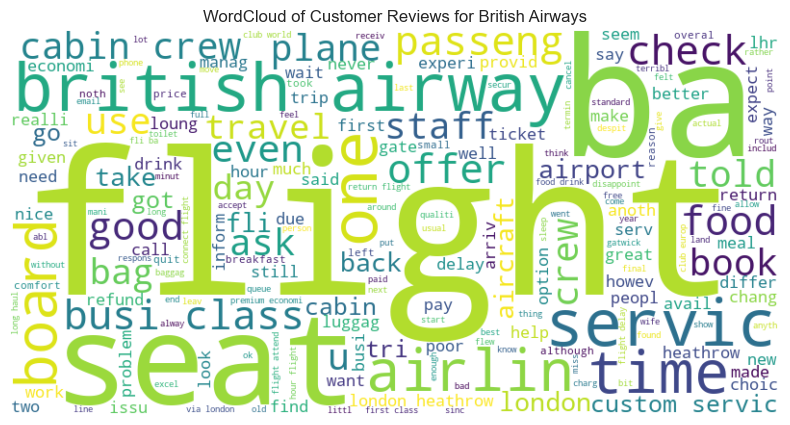

In [262]:

all_text = ' '.join(cleaned_reviews)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Customer Reviews for British Airways')
# plt.savefig('worldcloud_review.png', dpi=300, bbox_inches='tight') 
plt.show()


## Additional Task

### To further analyze the data I scraped, I built a Retrieval-Augmented Generation (RAG) system using Hugging Face embedding models and Gemini Pro. This allowed me to generate insightful, context-aware responses based on the scraped content.

In [221]:
api_key = 'insert your api key here'
genai.configure(api_key=api_key)

In [222]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "horizontal-veld-446019-m0-cf19f12da986.json"

In [240]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [241]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [242]:
data["context"] = data.apply(
    lambda row: f"This review is about a {row['seat_types']} experience. Here's what the customer said: {row['reviews']}",
    axis=1
)


In [243]:
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len
)

texts = data["context"].tolist()
chunked_docs = []
for text in texts:
    chunked_docs.extend(text_splitter.split_text(text))

docs = [Document(page_content=chunk) for chunk in chunked_docs]

In [244]:
vectordb = Chroma.from_documents(docs, embeddings, persist_directory="chroma_db")
vectordb.persist()

/opt/anaconda3/lib/python3.12/site-packages/chromadb/api/models/CollectionCommon.py:155: DeprecationWarning: legacy embedding function config
  return load_collection_configuration_from_json(self._model.configuration_json)


In [245]:
retriever = vectordb.as_retriever(search_kwargs={"k":15})

In [246]:
template ="""
You are a helpful AI assistant
Answer based on the context provided.
content:{context}
input:{input}
answer:
"""

In [247]:
prompt = PromptTemplate.from_template(template)

In [248]:
combine_docs_chain = create_stuff_documents_chain(model, prompt)

In [249]:
retrieval_chain = create_retrieval_chain(retriever,combine_docs_chain)

### Now  Asking the system questions based on the scraped data

In [253]:
question1 = "What is the context about?"

In [254]:
response1 = retrieval_chain.invoke({"input": question1})

In [255]:
display(Markdown(response1["answer"]))

The provided text consists of several customer reviews of British Airways flights, covering both Economy and Business Class experiences.  The reviews predominantly focus on negative experiences with cabin crew, citing rudeness, poor service, and unprofessional behavior.  Other issues mentioned include food quality, in-flight entertainment, baggage handling, and airline fees.

In [256]:
question2 = "What issue needs immediate attention?"

In [257]:
response2 = retrieval_chain.invoke({"input": question2})

In [258]:
display(Markdown(response2["answer"]))

Based on the provided reviews, several issues require immediate attention:

* **Ground staff incompetence and lack of communication:**  Multiple reviews highlight significant delays caused by ground staff errors (wrong flight documents, insufficient pushback tractors),  a lack of communication regarding delays, and unhelpful responses to passenger inquiries.  This points to a need for improved training, staffing levels, and communication protocols for ground crews.

* **Unresponsive customer service:**  Passengers report difficulties reaching customer service via phone and email, with long delays in responses or no response at all. This indicates a need for improved customer service channels and responsiveness.

* **Check-in process inefficiencies:** One review describes extremely long check-in queues with insufficient staff, leading to significant delays.  This suggests a need for better staffing and queue management at check-in desks.

While flight delays themselves are sometimes unavoidable, the consistent theme across these reviews is a lack of communication, poor customer service, and operational inefficiencies that exacerbate the negative passenger experience.  Addressing these systemic issues should be prioritized.

In [259]:
question3 = "Outline the top 5 issues?"

In [260]:
response3 = retrieval_chain.invoke({"input": question3})

In [261]:
display(Markdown(response3["answer"]))

Based on the provided reviews, the top 5 issues with British Airways are:

1. **Inconsistent Economy Class Experience:**  Reviews show a wide range of experiences in economy, from very poor (subpar entertainment, bad food, malfunctioning equipment, uncomfortable temperature) to quite positive (friendly staff, on-time flights, complimentary snacks).  This highlights a lack of consistency in service quality.

2. **Poor Business Class Service:** Multiple reviews heavily criticize the Business Class experience, citing long check-in queues, overcrowded lounges, significant flight delays, poor meal quality, and lack of timely drinks service.  This suggests a significant gap between advertised service and reality, especially considering the higher price point.

3. **Inadequate Food and Beverage:**  Both Economy and Business Class reviews frequently mention poor food and beverage quality,  with some describing it as "terrible" or "leaving something to be desired."

4. **Terminal 5 Issues:**  Several reviews specifically criticize Terminal 5 at Heathrow, mentioning chaos, long queues, and inconvenient bus transfers.  This suggests problems with ground operations and airport infrastructure.

5. **Inconsistent Staff Performance:** While some reviews praise the friendly and professional staff, others report bad service from staff. This indicates a need for improved staff training and consistent service standards.

#### TIP: you can include your questions

# TASK 2 -- Predicting customer buying behaviour

In [457]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

In [458]:

df = pd.read_csv(r'/Users/sot/Downloads/customer_booking.csv',encoding='ISO-8859-1')

In [459]:
# column names normalization

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [460]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [293]:
## Rearranging my coloumns because i prefer my target to be first

df2 = df[['booking_complete','num_passengers','sales_channel','trip_type','flight_day','route','booking_origin','purchase_lead','length_of_stay','flight_hour','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals','flight_duration']]

# EDA ON CATEGROICAL FEATURES

In [299]:
# sales channel 

df2['sales_channel'].value_counts()

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

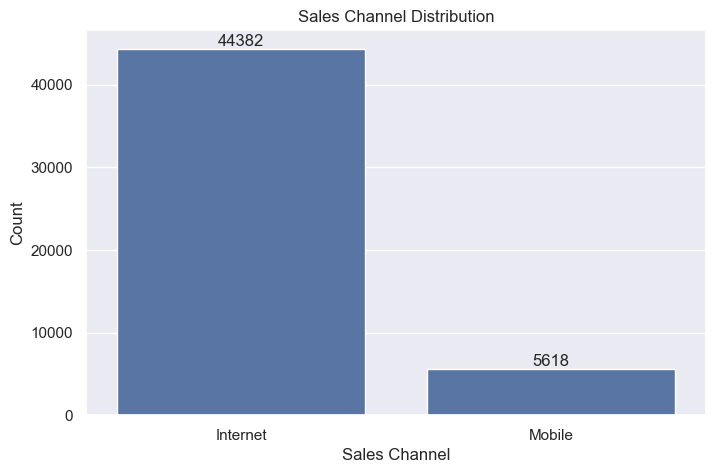

In [301]:


sales_channel_counts = df2['sales_channel'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sales_channel = sns.countplot(data=df2, x='sales_channel', order=sales_channel_counts.index)

for p in sales_channel.patches:
    sales_channel.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("Sales Channel Distribution")
plt.xlabel("Sales Channel")
plt.ylabel("Count")
plt.show()

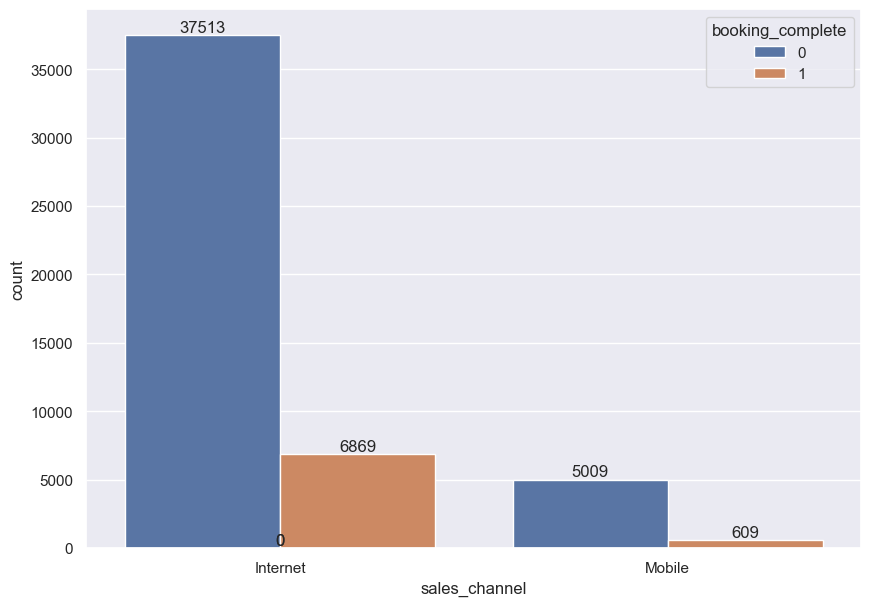

In [336]:
plt.figure(figsize=(10,7))
sales= sns.countplot(data = df,x = 'sales_channel',hue = 'booking_complete')

# Adding a  data labels to have idea of our  target count in each feature
for p in sales.patches:
 sales.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

In [369]:
## calculating the percentage of people who completed their booking successfully in the sales channel 

total_by_salesChannel = df.groupby('sales_channel').size()
booking_completed = df2[df2['booking_complete'] == 1].groupby('sales_channel').size()
percentage_of_booking_completed = booking_completed / total_by_salesChannel
percentage_of_booking_completed

sales_channel
Internet    0.154770
Mobile      0.108402
dtype: float64

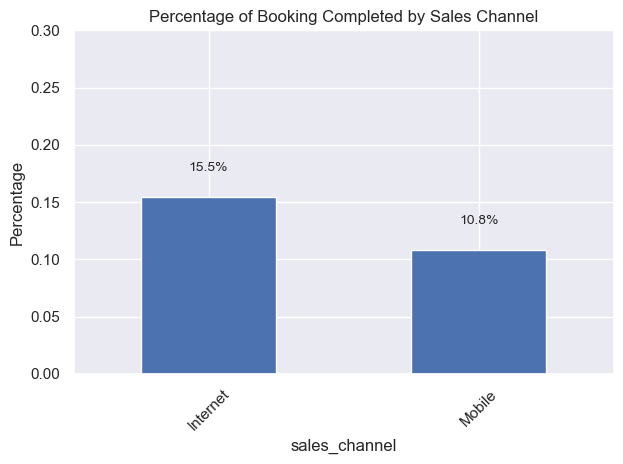

In [370]:
ax = percentage_of_booking_completed.plot(kind='bar')
plt.title('Percentage of Booking Completed by Sales Channel')
plt.ylabel('Percentage')
plt.ylim(0, 0.3)

for i, value in enumerate(percentage_of_booking_completed):
    plt.text(i, value + 0.02, f"{value:.1%}", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [302]:
# Trip type

df2['trip_type'].value_counts()

trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

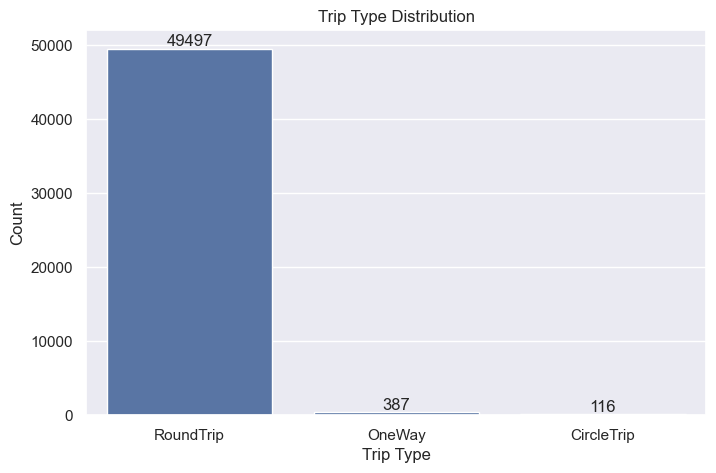

In [305]:
trip_type_counts = df2['trip_type'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
trip_type = sns.countplot(data=df2, x='trip_type', order=trip_type_counts.index)

for p in trip_type.patches:
   trip_type.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("Trip Type Distribution")
plt.xlabel("Trip Type")
plt.ylabel("Count")
plt.show()

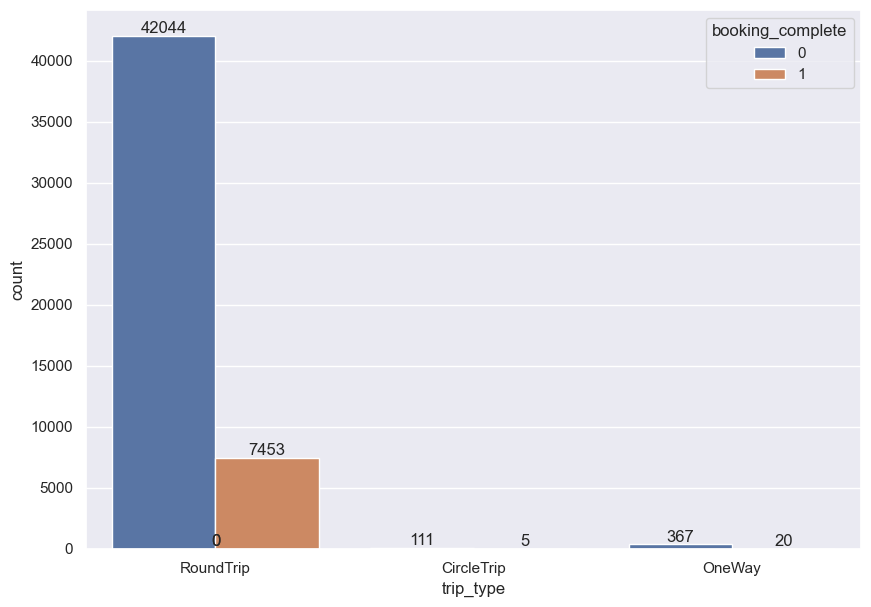

In [345]:
plt.figure(figsize=(10,7))
trip= sns.countplot(data = df,x = 'trip_type',hue = 'booking_complete')
for p in trip.patches:
 trip.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

In [361]:
## calculating the percentage of people who completed their booking successfully in Trip Type 

total_by_TripType = df.groupby('trip_type').size()
booking_completed = df2[df2['booking_complete'] == 1].groupby('trip_type').size()
percentage_of_booking_completed = booking_completed / total_by_TripType
percentage_of_booking_completed

trip_type
CircleTrip    0.043103
OneWay        0.051680
RoundTrip     0.150575
dtype: float64

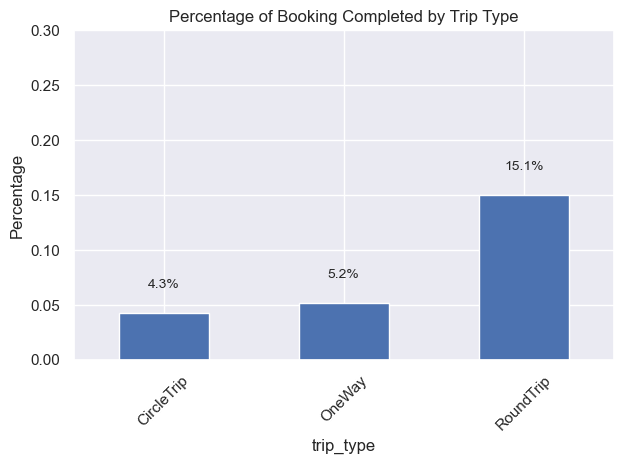

In [362]:
ax = percentage_of_booking_completed.plot(kind='bar')
plt.title('Percentage of Booking Completed by Trip Type')
plt.ylabel('Percentage')
plt.ylim(0, 0.3)

for i, value in enumerate(percentage_of_booking_completed):
    plt.text(i, value + 0.02, f"{value:.1%}", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insight:

#### from the  exploratory data analysis (EDA) above, i  observed that the dataset contains very few instances of "Round Trip" and "Circle Trip" travel types. Given the low volume, the model may struggle to learn meaningful patterns from these categories. One possible solution would be to combine these categories into a broader "Other" class through feature engineering. However, for now, I will proceed with training the model using the data as-is to evaluate its initial performance before applying any modifications.

In [363]:
# Flight Day 

df2['flight_day'].value_counts()

flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64

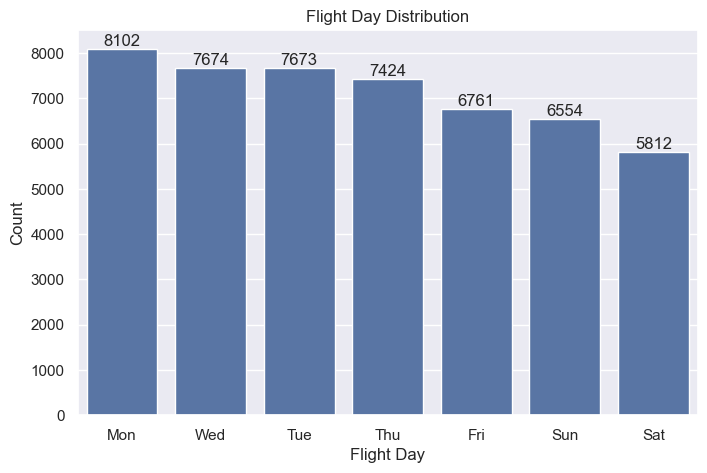

In [364]:
flight_day_counts = df2['flight_day'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
flight_day = sns.countplot(data=df2, x='flight_day', order=flight_day_counts.index)

for p in flight_day.patches:
   flight_day.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom'  
    )

plt.title("Flight Day Distribution")
plt.xlabel("Flight Day")
plt.ylabel("Count")
plt.show()

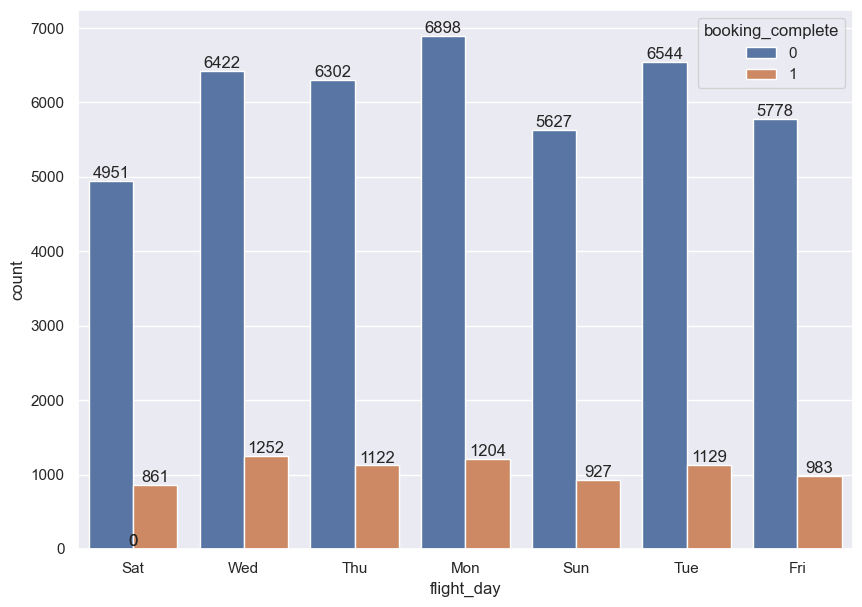

In [371]:
plt.figure(figsize=(10,7))
flight_day = sns.countplot(data = df,x = 'flight_day',hue = 'booking_complete')

# Adding a  data labels to have idea of our  target count in each feature
for p in flight_day.patches:
 flight_day.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

In [365]:
## calculating the percentage of people who completed their booking successfully in flight day

total_by_flight_day= df.groupby('flight_day').size()
booking_completed = df2[df2['booking_complete'] == 1].groupby('flight_day').size()
percentage_of_booking_completed = booking_completed / total_by_flight_day
percentage_of_booking_completed

flight_day
Fri    0.145393
Mon    0.148605
Sat    0.148142
Sun    0.141440
Thu    0.151131
Tue    0.147139
Wed    0.163148
dtype: float64

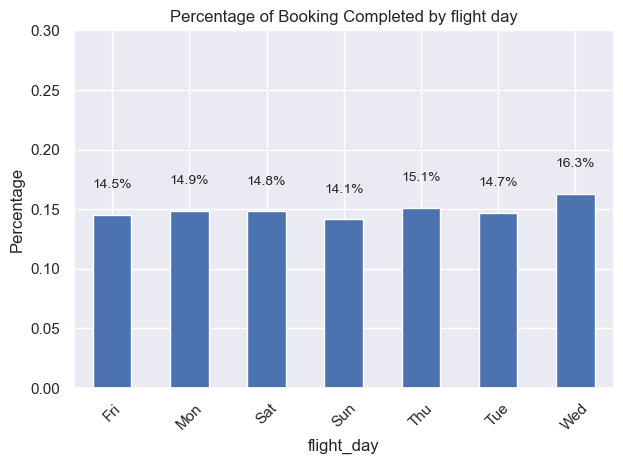

In [366]:
ax = percentage_of_booking_completed.plot(kind='bar')
plt.title('Percentage of Booking Completed by flight day')
plt.ylabel('Percentage')
plt.ylim(0, 0.3)

for i, value in enumerate(percentage_of_booking_completed):
    plt.text(i, value + 0.02, f"{value:.1%}", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [308]:
# Route
df2['route'].value_counts()

route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

In [316]:
# Booking_region
df['booking_origin'].value_counts()

booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

# Insight: 

#### Due to the high cardinality of the route and booking_origin features, I will initially drop them to evaluate the model's performance without them. If the performance is not satisfactory, I plan to engineer these features. For booking_origin, I will group the booking_origin into continents. As for the route feature, I’m currently unsure how best to group it. I intend to consult my team lead or someone with a deeper understanding of the routes, possibly a pilot from the BA team for guidance. 

#### That said, i am done with EDA on my categorical features, i will be using one-hot encoder for my encoding 

# EDA ON Numerical Features

<Axes: xlabel='booking_complete', ylabel='purchase_lead'>

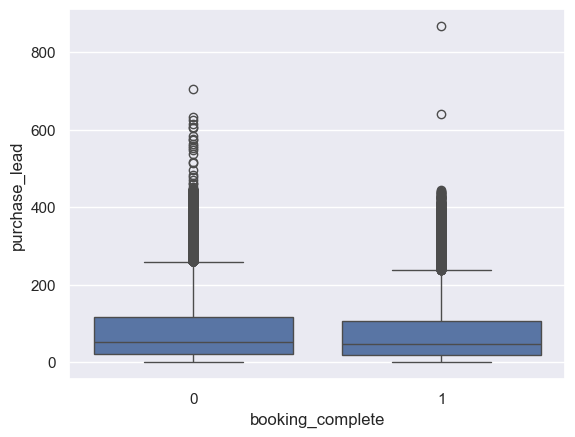

In [326]:
sns.boxplot(data = df2,x='booking_complete',y='purchase_lead')

<Axes: xlabel='booking_complete', ylabel='num_passengers'>

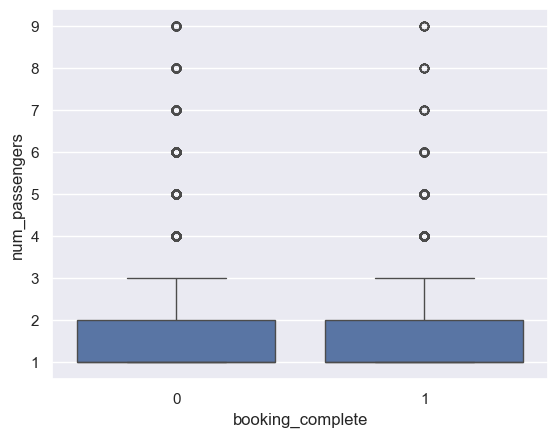

In [327]:
sns.boxplot(data = df2,x='booking_complete',y='num_passengers')

<Axes: xlabel='booking_complete', ylabel='length_of_stay'>

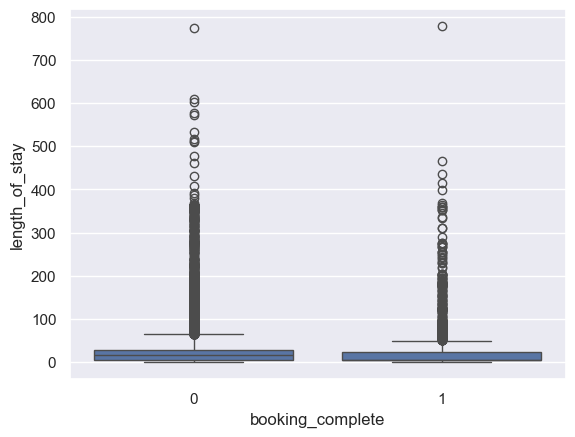

In [328]:
sns.boxplot(data = df2,x='booking_complete',y='length_of_stay')

<Axes: xlabel='booking_complete', ylabel='flight_hour'>

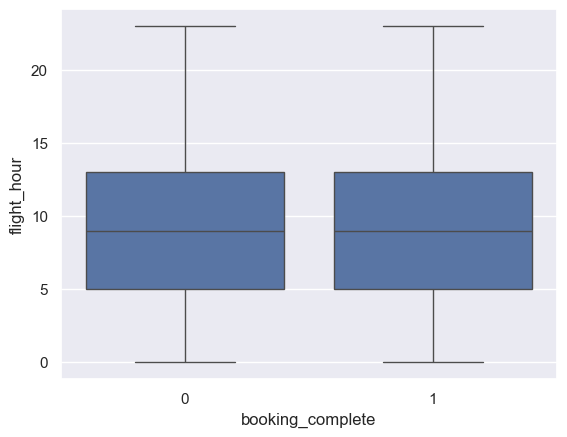

In [329]:
sns.boxplot(data = df2,x='booking_complete',y='flight_hour')

<Axes: xlabel='booking_complete', ylabel='flight_duration'>

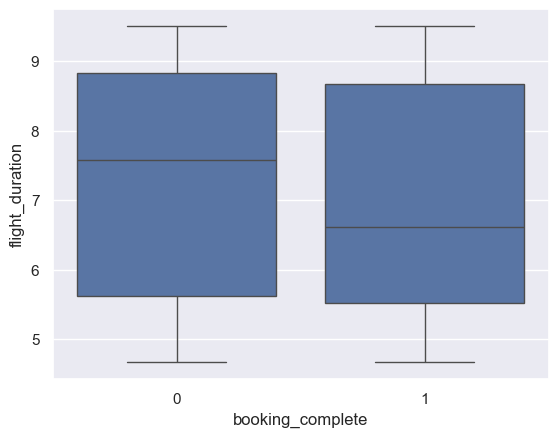

In [330]:
sns.boxplot(data = df2,x='booking_complete',y='flight_duration')

<Axes: xlabel='booking_complete', ylabel='wants_in_flight_meals'>

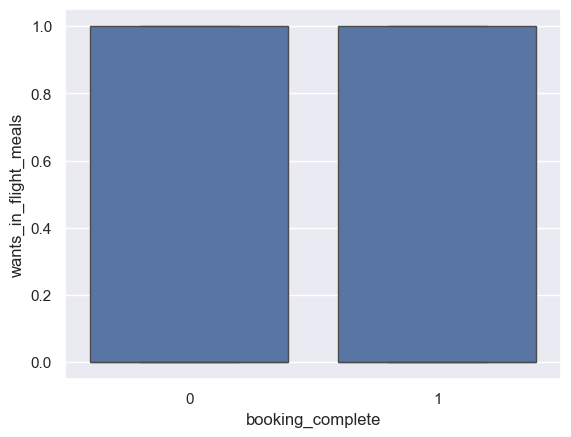

In [331]:
sns.boxplot(data = df2,x='booking_complete',y='wants_in_flight_meals')

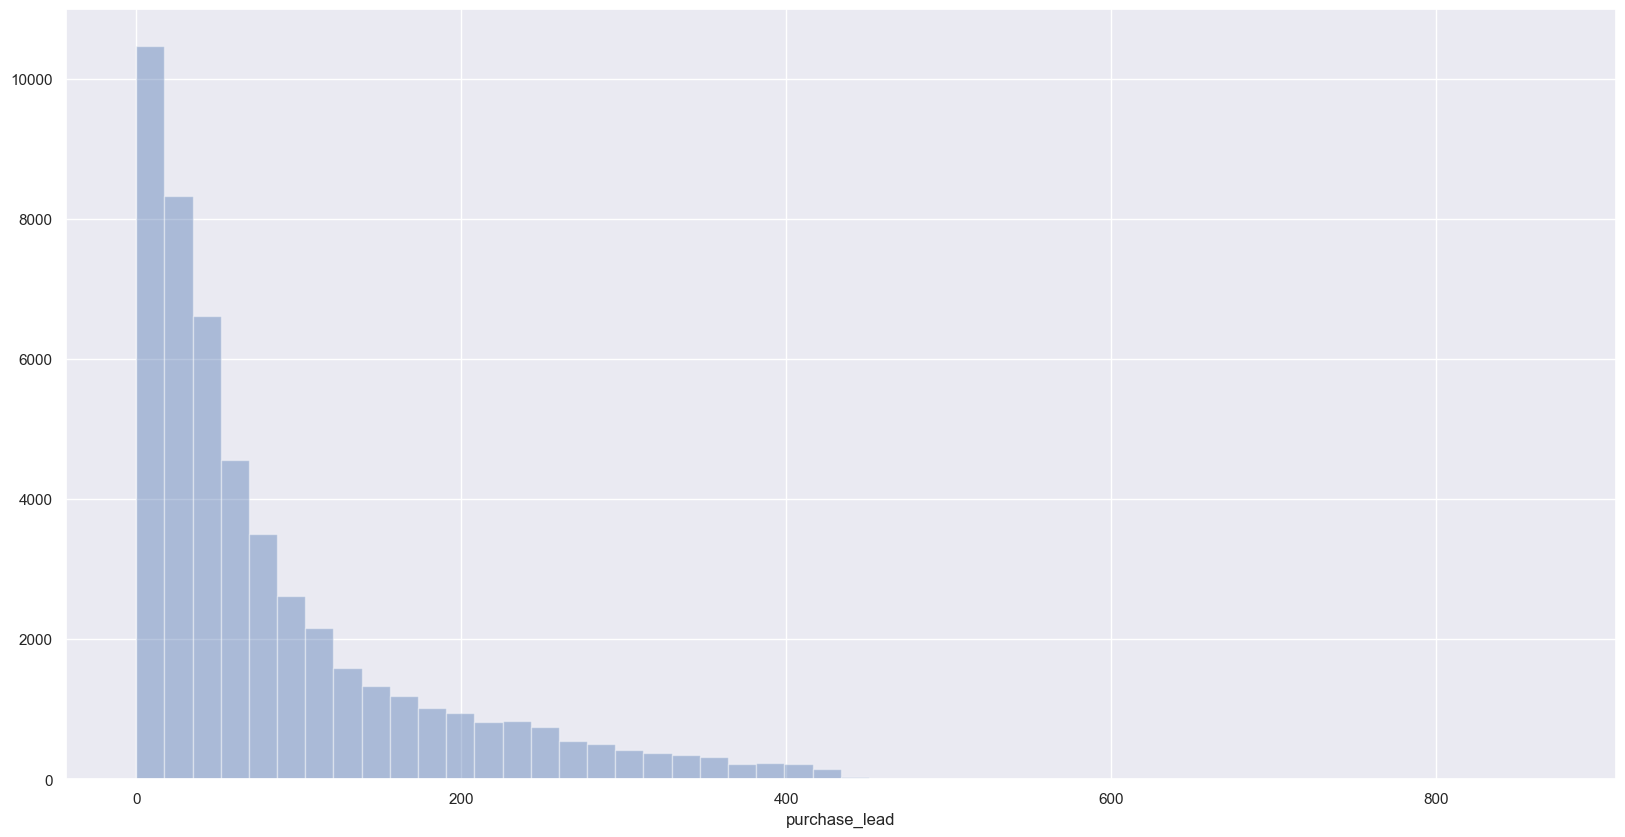

In [332]:

plt.figure(figsize = (20,10))
sns.distplot(df2['purchase_lead'],kde = False);

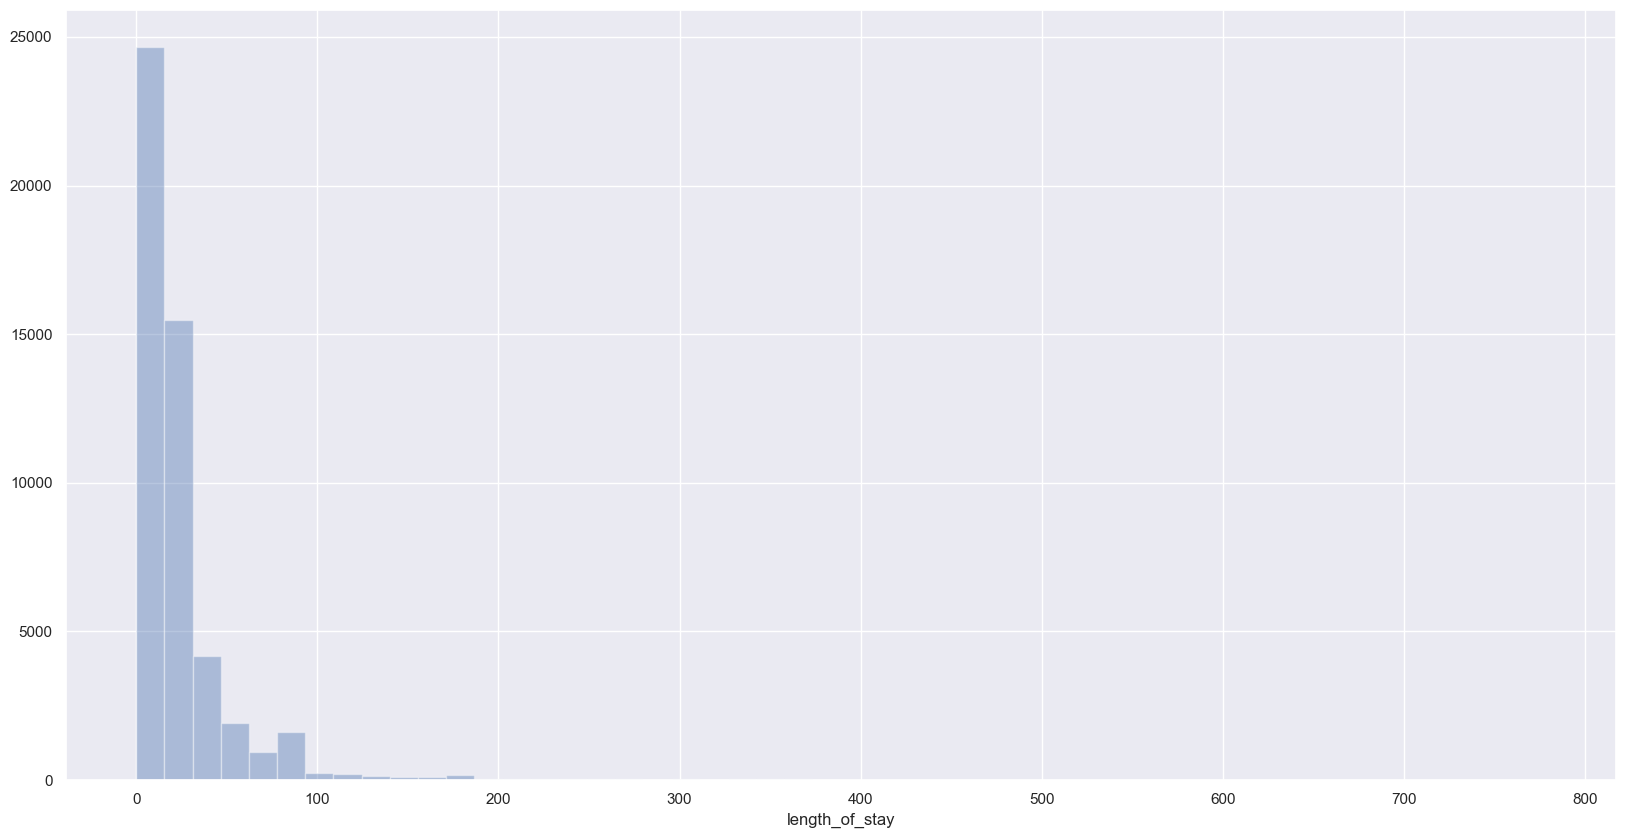

In [333]:

plt.figure(figsize = (20,10))
sns.distplot(df2['length_of_stay'],kde = False);

In [375]:
correlation = df[['booking_complete','num_passengers','purchase_lead','length_of_stay','flight_hour','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals','flight_duration']]
correlation.corr()

,booking_complete,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
booking_complete,1.000000,0.024116,-0.022131,-0.042408,0.007127,0.068139,0.050116,0.026511,-0.106266
num_passengers,0.024116,1.000000,0.212606,-0.115850,0.015607,0.120404,0.028544,0.022943,-0.063169
purchase_lead,-0.022131,0.212606,1.000000,-0.076560,0.035973,-0.022207,-0.004499,-0.022653,0.067866
length_of_stay,-0.042408,-0.115850,-0.076560,1.000000,-0.024872,0.176757,0.032264,0.098828,0.141181
flight_hour,0.007127,0.015607,0.035973,-0.024872,1.000000,-0.011434,0.012171,0.013014,-0.002101
wants_extra_baggage,0.068139,0.120404,-0.022207,0.176757,-0.011434,1.000000,0.207669,0.216470,0.057054
wants_preferred_seat,0.050116,0.028544,-0.004499,0.032264,0.012171,0.207669,1.000000,0.315088,0.101289
wants_in_flight_meals,0.026511,0.022943,-0.022653,0.098828,0.013014,0.216470,0.315088,1.000000,0.154312
flight_duration,-0.106266,-0.063169,0.067866,0.141181,-0.002101,0.057054,0.101289,0.154312,1.000000


<Axes: >

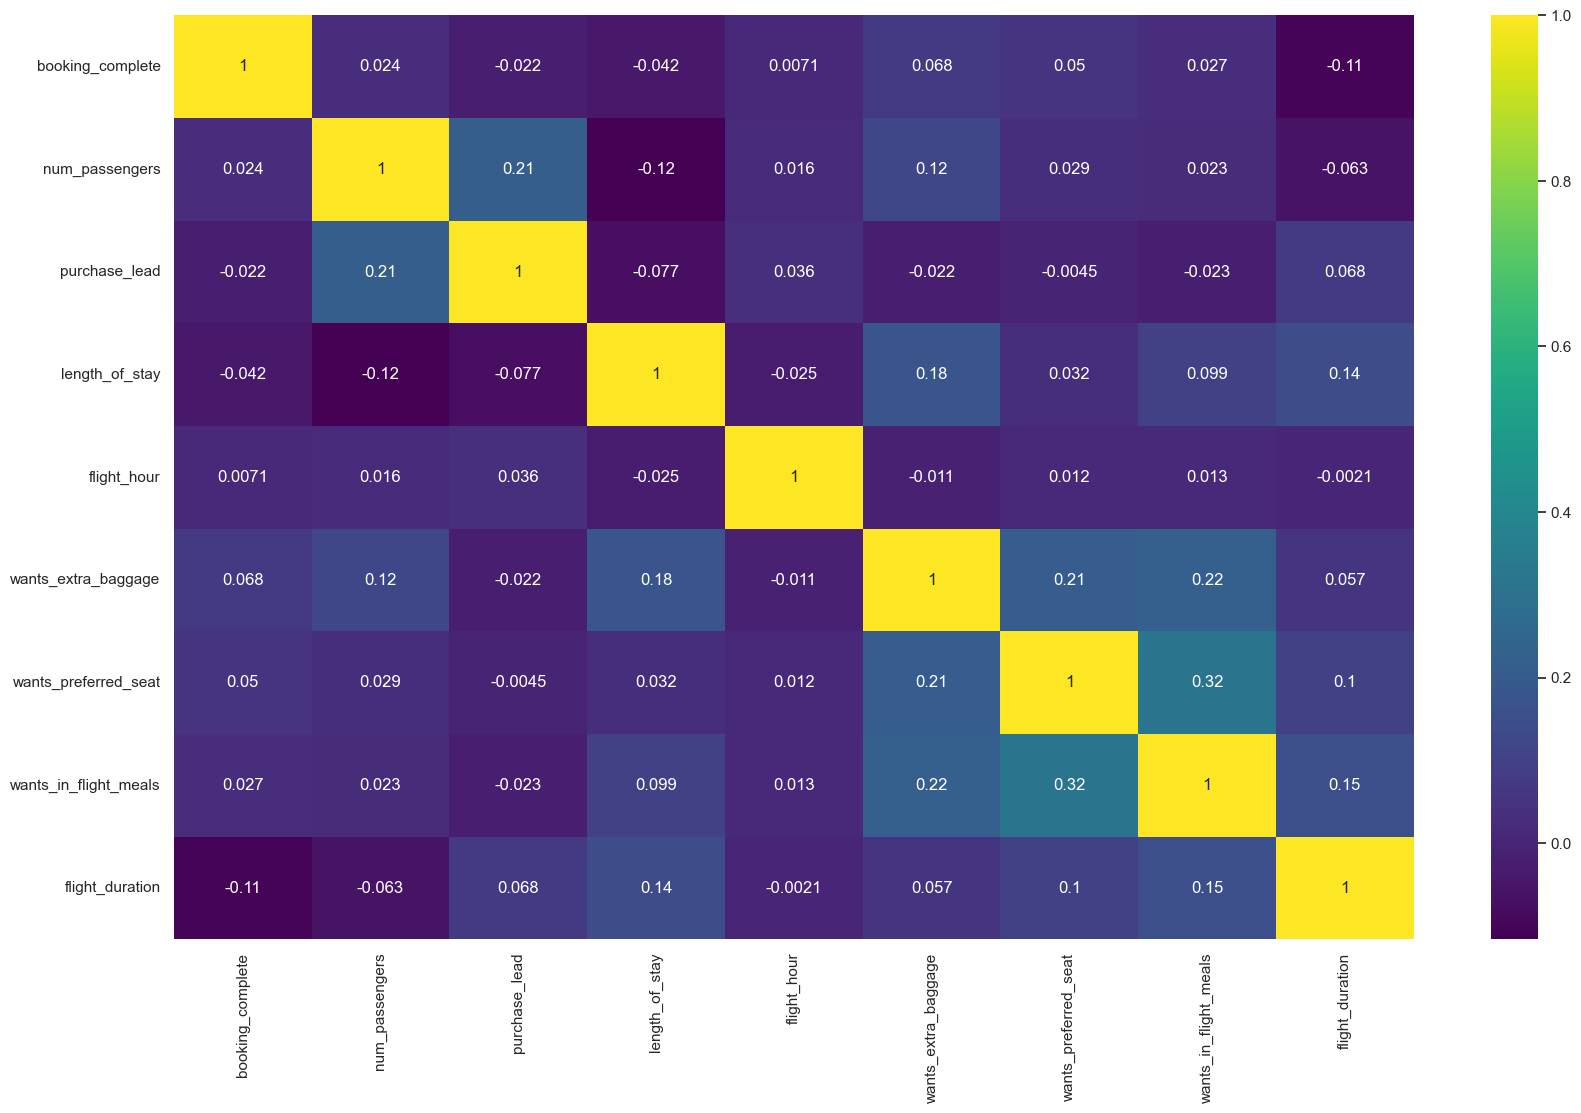

In [374]:
plt.figure(figsize=(20,12))

sns.heatmap(correlation,annot = True,cmap= 'viridis')

<Axes: >

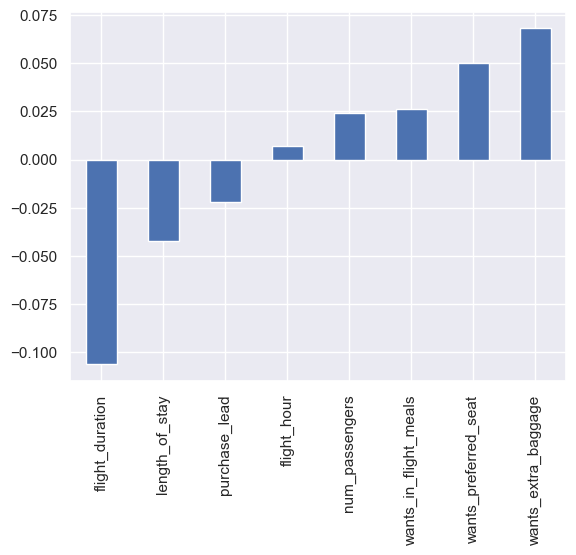

In [376]:
correlation.corr()['booking_complete'].sort_values().drop('booking_complete').plot(kind ='bar')

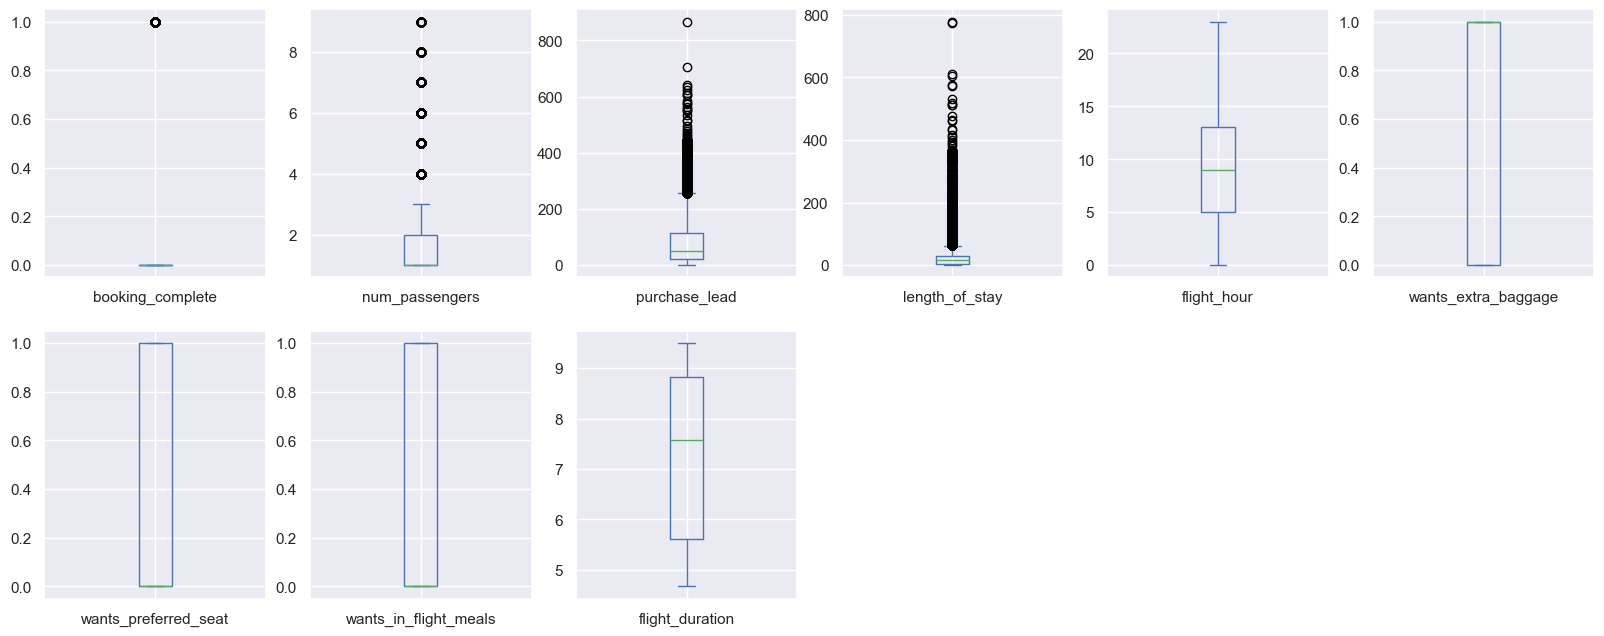

In [377]:
correlation.plot(
     kind = 'box',
    subplots = True,
    figsize =(20,16),
    layout = (4,6) 
);

In [380]:
 #Calculate Q1 and Q3

Q1 =correlation.quantile(0.25)
Q3 =correlation.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = pd.DataFrame()

for column in correlation:
    outlier_mask = (correlation[column] < lower_bound[column]) | (correlation[column] > upper_bound[column])
    outliers = pd.concat([outliers, correlation[column][outlier_mask]], axis=1)

In [455]:
 outliers.count()

booking_complete         7478
num_passengers           2903
purchase_lead            3456
length_of_stay           3807
flight_hour                 0
wants_extra_baggage         0
wants_preferred_seat        0
wants_in_flight_meals       0
flight_duration             0
dtype: int64

In [382]:
len(outliers)

15564

In [384]:
len(df)

50000

In [385]:
50000 * 0.05     # the len of the outliers is greater than o.5 of the data

2500.0

## Visualizing further the features with the outliers

<Axes: xlabel='num_passengers', ylabel='Density'>

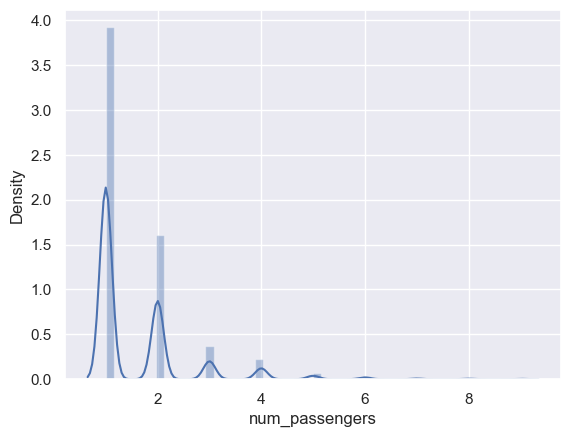

In [387]:
sns.distplot(df['num_passengers'])

<Axes: xlabel='purchase_lead', ylabel='Density'>

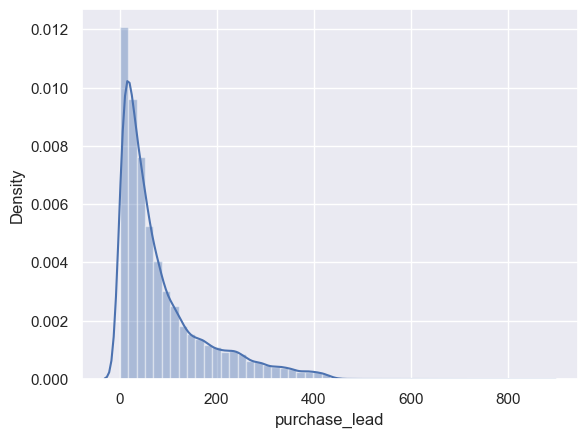

In [388]:
sns.distplot(df['purchase_lead'])

<Axes: xlabel='length_of_stay', ylabel='Density'>

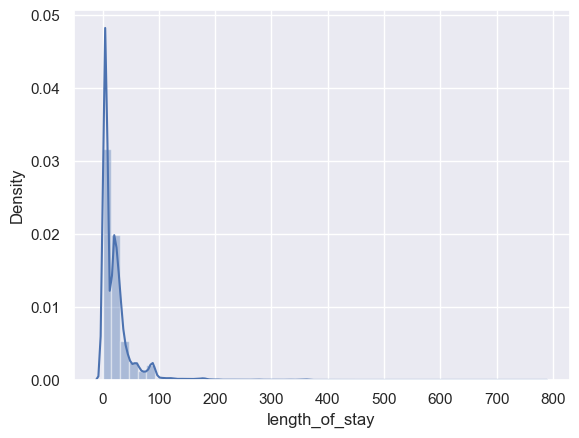

In [390]:
sns.distplot(df['length_of_stay'])

# Insights:


###  After examining the correlation matrix, none of the features show a strong linear correlation with the target variable booking_complete. The highest positive correlation is observed with wants_extra_baggage (0.068) and wants_preferred_seat (0.050), while flight_duration has the strongest negative correlation (-0.106). This indicates that while these features may hold some predictive value, their individual linear relationship with the target is weak — emphasizing the need for a model that can capture more complex patterns.

## Additionally, based on the outliers check:

#### Features with potential outliers include: num_passengers, purchase_lead, and length_of_stay.

#### However, since these outliers are over 5% of the total data, I will not remove them outright to avoid unnecessary data loss.

# Action Plan

- I will build and evaluate the model with the outliers included.

- Then, I will build the same model after removing or capping the outliers.



## Data preprocessing 

In [401]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
 14  route_grouped          50000 non-null  object 
dtypes:

In [405]:
df2.isnull().sum()

booking_complete         0
num_passengers           0
sales_channel            0
trip_type                0
flight_day               0
route                    0
booking_origin           0
purchase_lead            0
length_of_stay           0
flight_hour              0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
dtype: int64

In [406]:
# check for duplicate 
df2.duplicated().sum()

719

In [407]:
df2.drop_duplicates(inplace=True)

In [409]:
df2.reset_index(drop=True, inplace=True)

In [422]:
df3 =df2.drop(['route', 'booking_origin'], axis=1)


In [424]:
X = df3.drop(['booking_complete'], axis = 1)
y = df3['booking_complete']

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [427]:

x_train_dummies = pd.get_dummies(X_train, dtype = int, drop_first = True)
x_test_dummies= pd.get_dummies(X_test, dtype = int, drop_first = True)

In [428]:
## i used minmax scaler because it scales between 0 and 1 and originally have 0's and 1's in my dataset, needed to be  consistent with that 

scaler = MinMaxScaler()
scaler.fit(x_train_dummies)

MinMaxScaler()

In [429]:
x_train_scaled= scaler.transform(x_train_dummies)
x_test_scaled = scaler.transform(x_test_dummies)

<Axes: xlabel='booking_complete', ylabel='count'>

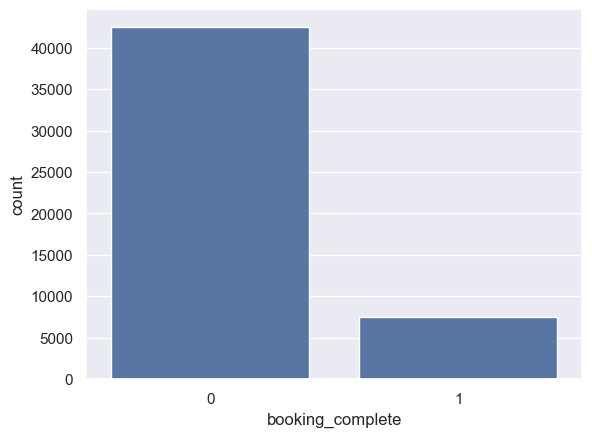

In [415]:
sns.countplot(data = df,x = 'booking_complete')

# INSIGHT:

### It’s clear that the target variable is imbalanced, which poses a common challenge in classification tasks and can lead to the accuracy paradox, where a model appears to perform well based on accuracy but actually fails to capture the minority class effectively. To address this, I will apply resampling techniques and compare model performance with and without resampling.

#### If you're interested in learning more about the accuracy paradox, feel free to check out my blog post on Medium:
### 🔗 [Beware of the Accuracy Trap](https://medium.com/@edosomapatrick41/beware-of-the-accuracy-trap-4785d07cdd8a)

In [430]:
from imblearn.under_sampling import TomekLinks,NearMiss
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTETomek

def sampler_function(data_x, data_y, sampler = 0, random_state = 42):
    
    if sampler == 0:
        sampler = RandomOverSampler(random_state = random_state)
    elif sampler == 1:
        sampler = TomekLinks()
    elif sampler == 2:
        sampler = SMOTE()
    elif sampler == 3:
        sampler = SMOTETomek()
    else: 
        sampler = NearMiss()
    X_transformed, y_transformed = sampler.fit_resample(data_x, data_y)
    
    print('Original dataset shape:', data_y.shape)
    print('Resample dataset shape:', y_transformed.shape)
    
    return X_transformed, y_transformed

In [431]:
X_train_res, y_train_res = sampler_function(x_train_scaled, y_train,sampler =2)

Original dataset shape: (39424,)
Resample dataset shape: (67024,)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [438]:
## Oversampled successfully with smote 

y_train_res.value_counts()

booking_complete
0    33512
1    33512
Name: count, dtype: int64

In [439]:

def train_and_evaluate_classifiers(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "K-Nearest Neighbors": KNeighborsClassifier()
        
    }

    results = []

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec_0 = precision_score(y_test, y_pred, pos_label=0)
        prec_1 = precision_score(y_test, y_pred, pos_label=1)
        rec_0 = recall_score(y_test, y_pred, pos_label=0)
        rec_1 = recall_score(y_test, y_pred, pos_label=1)
        f1_0 = f1_score(y_test, y_pred, pos_label=0)
        f1_1 = f1_score(y_test, y_pred, pos_label=1)
        cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

        results.append([
            model_name, acc, prec_0, prec_1, rec_0, rec_1, f1_0, f1_1, cv_acc
        ])

    results_df = pd.DataFrame(results, columns=[
        "Model", "Accuracy", "Precision (0)", "Precision (1)",
        "Recall (0)", "Recall (1)", "F1 Score (0)", "F1 Score (1)", "CV Accuracy"
    ])

    return results_df


In [444]:
Model_performance_WITHOUT_resampling_techniques = train_and_evaluate_classifiers(x_train_scaled, x_test_scaled, y_train, y_test)


In [445]:
Model_performance_WITHOUT_resampling_techniques

,Model,Accuracy,Precision (0),Precision (1),Recall (0),Recall (1),F1 Score (0),F1 Score (1),CV Accuracy
0,Logistic Regression,0.849954,0.849954,0.000000,1.000000,0.000000,0.918892,0.000000,0.850041
1,Decision Tree,0.760373,0.866650,0.232910,0.848651,0.260311,0.857556,0.245849,0.751573
2,Random Forest,0.844983,0.854042,0.366120,0.986154,0.045301,0.915356,0.080626,0.845500
3,Gradient Boosting,0.849853,0.850010,0.333333,0.999761,0.000676,0.918824,0.001350,0.849762
4,AdaBoost,0.849954,0.850167,0.500000,0.999642,0.002028,0.918866,0.004040,0.849736
5,K-Nearest Neighbors,0.831592,0.854175,0.257373,0.966937,0.064909,0.907065,0.103672,0.829165


In [442]:
Model_performance_with_resampling_techniques = train_and_evaluate_classifiers(X_train_res, x_test_scaled, y_train_res, y_test)


In [443]:
Model_performance_with_resampling_techniques

,Model,Accuracy,Precision (0),Precision (1),Recall (0),Recall (1),F1 Score (0),F1 Score (1),CV Accuracy
0,Logistic Regression,0.595414,0.890708,0.204058,0.597279,0.584855,0.715061,0.302553,0.601009
1,Decision Tree,0.734808,0.861515,0.198939,0.819766,0.253550,0.840122,0.222949,0.817230
2,Random Forest,0.818809,0.858495,0.268477,0.942110,0.120352,0.898361,0.166200,0.888205
3,Gradient Boosting,0.823476,0.858966,0.286416,0.947959,0.118323,0.901271,0.167464,0.825064
4,AdaBoost,0.750025,0.882338,0.268017,0.814514,0.384719,0.847071,0.315936,0.756983
5,K-Nearest Neighbors,0.626560,0.870134,0.186503,0.658988,0.442867,0.749983,0.262472,0.770038


# INSIGHT:

### As expected, models trained on imbalanced data—without resampling or stratification—produced misleadingly high accuracy but performed poorly in capturing the minority class. Although the performance after applying resampling techniques like SMOTE was not exceptionally strong, it showed meaningful improvement compared to the original setup.

### After resampling, Random Forest emerged as the best-performing model with a cross-validation accuracy of 88%.

### For this phase of the project, I intentionally kept things simple to focus on generating actionable insights. However, if further performance improvement is required by my team lead , I would have explored these steps :

### -- Feature engineering: Creating new features or transforming existing ones to better capture patterns.

### -- Feature selection: Dropping redundant or low-importance features based on importance scores.

### -- Outlier removal: Identifying and excluding extreme values that may distort model learning.

### -- Hyperparameter tuning: Optimizing model parameters using techniques like GridSearchCV.

##  Implementing the steps above would definitely improve the model performance

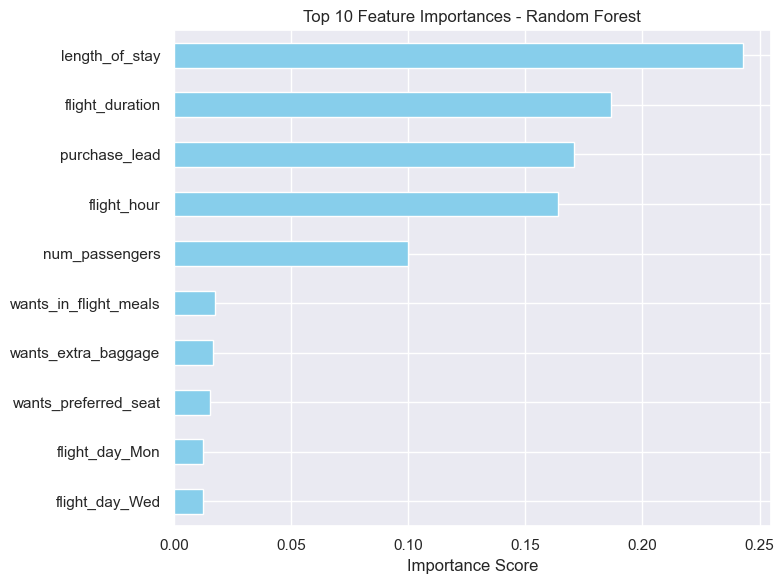

In [448]:
# Checking feature importance for my analysis


rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)
importances = pd.Series(rf.feature_importances_, index=x_train_dummies.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()


In [450]:
top_features

length_of_stay           0.242721
flight_duration          0.186498
purchase_lead            0.170914
flight_hour              0.163769
num_passengers           0.100162
wants_in_flight_meals    0.017742
wants_extra_baggage      0.016830
wants_preferred_seat     0.015321
flight_day_Mon           0.012640
flight_day_Wed           0.012426
dtype: float64

## THE END 

# MY Portfolio: https://www.datascienceportfol.io/Patrick090